# Definicao Inicial

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import unicodedata
import re

# ============================================================================
# CONFIGURAÇÕES VISUAIS
# ============================================================================
PRIMARY_PURPLE = "#8c52ff"
GREY_ITIP = "#9e9e9e"
plt.rcParams["font.family"] = "sans-serif"
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# ============================================================================
# FUNÇÕES AUXILIARES
# ============================================================================
def format_currency_br(x, pos):
    """Formata valores em reais com notação K/M"""
    if x >= 1e6:
        return f"R${x*1e-6:.1f}M"
    elif x >= 1000:
        return f"R${x*1e-3:.0f}K"
    return f"R${x:.0f}"


def get_month_name(month_int):
    """Retorna abreviação do nome do mês"""
    months = {
        1: "Jan",
        2: "Fev",
        3: "Mar",
        4: "Abr",
        5: "Mai",
        6: "Jun",
        7: "Jul",
        8: "Ago",
        9: "Set",
        10: "Out",
        11: "Nov",
        12: "Dez",
    }
    return months.get(month_int, "")


def _normalize_text(s: str) -> str:
    """Remove acentos e normaliza texto"""
    if s is None:
        return ""
    s = str(s).replace("\xa0", " ").strip()
    s_norm = unicodedata.normalize("NFKD", s)
    s_norm = "".join(ch for ch in s_norm if not unicodedata.combining(ch))
    return re.sub(r"\s+", " ", s_norm).lower()


def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Normaliza nomes das colunas para formato padrão"""
    mapping = {
        "nome do projeto": "Nome do Projeto",
        "nucleo": "Núcleo",
        "núcleo": "Núcleo",
        "portfolio": "Portfólio",
        "portfólio": "Portfólio",
        "classificacao": "Classificação",
        "classificação": "Classificação",
        "valor": "Valor",
        "origem": "Origem",
        "tempo em contrato (semanas)": "Tempo em contrato (semanas)",
        "nº consultores": "Nº Consultores",
        "no consultores": "Nº Consultores",
        "itip": "ITIP",
        "data assinatura cliente": "Data Assinatura Cliente",
        "empresa": "Empresa",
        "aditivo?": "Aditivo?",
    }
    new_cols = {}
    for c in df.columns:
        key = _normalize_text(c)
        new_cols[c] = mapping.get(key, c.strip())
    return df.rename(columns=new_cols)


def parse_brl_series(s: pd.Series) -> pd.Series:
    """Converte strings em formato BRL (R$ 1.234,56) para float"""
    if s is None:
        return pd.Series(dtype=float)

    def _parse_one(x):
        if pd.isna(x):
            return np.nan
        x = str(x).replace("R$", "").replace("r$", "")
        x = x.replace(".", "").replace(" ", "").replace(",", ".")
        try:
            return float(x)
        except ValueError:
            return np.nan

    return s.apply(_parse_one)


# ============================================================================
# FUNÇÕES DE PLOTAGEM
# ============================================================================
def plot_butterfly_final(df):
    """Gráfico butterfly para análise de 2023"""
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

    max_ticket = df["Ticket"].max()
    max_itip = df["ITIP"].max()
    limit_ticket = np.ceil(max_ticket / 5000) * 5000
    limit_itip = np.ceil(max_itip / 5000) * 5000
    offset_ticket = limit_ticket * 0.02
    offset_itip = limit_itip * 0.02

    # Ticket Médio (Esquerda)
    bars1 = ax1.barh(df["Solucao"], df["Ticket"], color=PRIMARY_PURPLE, height=0.6)
    ax1.set_title(
        "Ticket Médio (R$)",
        fontsize=12,
        color=PRIMARY_PURPLE,
        fontweight="bold",
        pad=15,
    )
    ax1.invert_xaxis()
    ax1.set_xlim(limit_ticket, 0)
    ax1.spines["top"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_color("#cccccc")
    ax1.tick_params(left=False)

    for bar in bars1:
        width = bar.get_width()
        ax1.text(
            width + offset_ticket,
            bar.get_y() + bar.get_height() / 2,
            f" R${width/1000:.1f}k",
            va="center",
            ha="right",
            color="#333",
            fontweight="bold",
            fontsize=10,
        )

    # ITIP (Direita)
    bars2 = ax2.barh(df["Solucao"], df["ITIP"], color=GREY_ITIP, height=0.6)
    ax2.set_title(
        "ITIP (R$/Semana)", fontsize=12, color="#666", fontweight="bold", pad=15
    )
    ax2.set_xlim(0, limit_itip)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_color("#cccccc")
    ax2.tick_params(left=False)

    for bar in bars2:
        width = bar.get_width()
        ax2.text(
            width + offset_itip,
            bar.get_y() + bar.get_height() / 2,
            f" R${width:.0f}",
            va="center",
            ha="left",
            color="#333",
            fontweight="bold",
            fontsize=10,
        )

    ax1.tick_params(axis="y", labelsize=11, pad=20)
    plt.subplots_adjust(wspace=0.0)
    fig.suptitle(
        "Performance de Soluções 2023: Ticket vs. Esforço",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )
    plt.tight_layout()
    plt.show()


def plot_receita_por_canal(df, semester_name, month_range):
    """Gráfico 1: Receita por Canal (Stacked Bar)"""
    df_pivot = df.pivot_table(
        index="Mes", columns="Origem", values="Valor", aggfunc="sum", fill_value=0
    )
    df_pivot = df_pivot.reindex(month_range, fill_value=0)
    df_pivot.index = [get_month_name(m) for m in df_pivot.index]

    fig, ax = plt.subplots(figsize=(12, 6))

    from matplotlib.colors import to_rgb

    n_colors = len(df_pivot.columns)
    if n_colors > 1:
        colors = sns.dark_palette(PRIMARY_PURPLE, n_colors=n_colors)
        colors[0] = to_rgb(GREY_ITIP)
    else:
        colors = [PRIMARY_PURPLE]

    df_pivot.plot(
        kind="bar", stacked=True, color=colors, ax=ax, width=0.7, edgecolor="white"
    )

    # Calcular limite do eixo Y (próximo múltiplo de 50k)
    max_value = df_pivot.sum(axis=1).max()
    y_limit = np.ceil(max_value / 50000) * 50000
    ax.set_ylim(0, y_limit)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("#cccccc")
    ax.grid(axis="y", linestyle="--", alpha=0.7, color="#cccccc")
    ax.set_axisbelow(True)
    ax.set_title(
        f"Receita por Canal - {semester_name}", loc="left", fontweight="bold", pad=20
    )
    ax.set_ylabel("Receita")
    ax.yaxis.set_major_formatter(FuncFormatter(format_currency_br))
    plt.xticks(rotation=0)
    plt.legend(frameon=False, ncol=5, bbox_to_anchor=(0.5, 1.05), loc="lower center")
    plt.tight_layout()
    plt.show()


def plot_faturamento_acumulado(df, semester_name, month_range):
    """Gráfico 2: Faturamento vs Acumulado (Combo)"""
    df_fat = (
        df.groupby("Mes")["Valor"]
        .sum()
        .reindex(month_range, fill_value=0)
        .reset_index()
    )
    df_fat["Acumulado"] = df_fat["Valor"].cumsum()
    df_fat["Mês"] = df_fat["Mes"].apply(get_month_name)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.barplot(x="Mês", y="Valor", data=df_fat, ax=ax1, color=PRIMARY_PURPLE)
    ax2 = ax1.twinx()
    sns.lineplot(
        x="Mês",
        y="Acumulado",
        data=df_fat,
        ax=ax2,
        color="#9e9e9e",
        linewidth=3,
        marker="o",
    )

    # Calcular limites dos eixos Y
    max_mensal = df_fat["Valor"].max()
    max_acumulado = df_fat["Acumulado"].max()
    y1_limit = np.ceil(max_mensal / 50000) * 50000
    y2_limit = np.ceil(max_acumulado / 100000) * 100000
    ax1.set_ylim(0, y1_limit)
    ax2.set_ylim(0, y2_limit)

    ax1.spines["top"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax1.spines["left"].set_visible(True)
    ax1.spines["left"].set_color("#cccccc")
    ax2.spines["right"].set_visible(True)
    ax2.spines["right"].set_color("#cccccc")
    ax1.grid(axis="y", linestyle="--", alpha=0.7, color="#cccccc")
    ax1.set_axisbelow(True)
    ax1.set_ylabel("Mensal")
    ax2.set_ylabel("Acumulado")
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency_br))
    ax2.yaxis.set_major_formatter(FuncFormatter(format_currency_br))
    ax1.set_title(
        f"Faturamento vs Acumulado - {semester_name}",
        loc="left",
        fontweight="bold",
        pad=20,
    )
    plt.tight_layout()
    plt.show()


def plot_ticket_itip_butterfly(df, semester_name):
    """Gráfico 3: Ticket vs ITIP por Portfólio (Butterfly)"""
    portfolios_validos = [
        "Inteligência de Negócios",
        "Ciência de Dados",
        "Engenharia de Dados",
        "DSaaS",
        "Inteligência Artificial",
    ]
    df_filtered = df[df["Portfólio"].isin(portfolios_validos)]

    if df_filtered.empty:
        print(f"Aviso: Nenhum portfólio válido encontrado para {semester_name}")
        return

    df_agg = (
        df_filtered.groupby("Portfólio")
        .agg({"Valor": "mean", "ITIP": "mean"})
        .reset_index()
    )
    df_agg = df_agg.sort_values("Valor", ascending=True)

    df_agg["Portfólio"] = df_agg["Portfólio"].replace(
        {
            "Inteligência de Negócios": "IN",
            "Ciência de Dados": "CD",
            "Engenharia de Dados": "ED",
            "Inteligência Artificial": "IA",
        }
    )

    max_valor = df_agg["Valor"].max()
    max_itip = df_agg["ITIP"].max()
    limit_valor = np.ceil(max_valor / 5000) * 5000
    limit_itip = max_itip * 1.25
    offset_valor = limit_valor * 0.005
    offset_itip = limit_itip * 0.02

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

    # Ticket Médio
    ax1.barh(df_agg["Portfólio"], df_agg["Valor"], color=PRIMARY_PURPLE, height=0.6)
    ax1.set_title("Ticket Médio (R$)", color=PRIMARY_PURPLE, fontweight="bold")
    ax1.invert_xaxis()
    ax1.set_xlim(limit_valor, 0)
    ax1.spines["top"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(True)
    ax1.spines["bottom"].set_color("#cccccc")
    ax1.grid(axis="x", linestyle="--", alpha=0.7, color="#cccccc")
    ax1.set_axisbelow(True)
    ax1.tick_params(axis="y", pad=40)

    for i, v in enumerate(df_agg["Valor"]):
        ax1.text(
            v + offset_valor,
            i,
            f"{v:,.0f}",
            va="center",
            ha="right",
            fontweight="bold",
        )

    # ITIP
    ax2.barh(df_agg["Portfólio"], df_agg["ITIP"], color="#9e9e9e", height=0.6)
    ax2.set_title("ITIP (R$/Semana)", color="#666", fontweight="bold")
    ax2.set_xlim(0, limit_itip)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_visible(True)
    ax2.spines["bottom"].set_color("#cccccc")
    ax2.grid(axis="x", linestyle="--", alpha=0.7, color="#cccccc")
    ax2.set_axisbelow(True)

    for i, v in enumerate(df_agg["ITIP"]):
        ax2.text(
            v + offset_itip, i, f" {v:,.0f} ", va="center", ha="left", fontweight="bold"
        )

    fig.suptitle(
        f"Eficiência Comercial: Ticket vs ITIP - {semester_name}", fontweight="bold"
    )
    plt.subplots_adjust(wspace=0.05)
    plt.show()


def calcular_estatisticas(df, semester_name, month_range):
    """Calcula e exibe estatísticas do semestre"""
    print(f"\n{'='*60}")
    print(f"ESTATÍSTICAS - {semester_name}")
    print(f"{'='*60}")

    # Valor total do semestre
    valor_total = df["Valor"].sum()
    print(f"Valor Total do Semestre: R$ {valor_total:,.2f}")

    # Valor por mês
    print(f"\nValor por Mês:")
    for mes in month_range:
        valor_mes = df[df["Mes"] == mes]["Valor"].sum()
        nome_mes = get_month_name(mes)
        print(f"  {nome_mes}: R$ {valor_mes:,.2f}")

    print(f"{'='*60}\n")

# Análise 2023

In [ ]:
# Dados 2023
data_2023 = {
    "Solucao": ["View", "INT", "Aut", "EXT", "Prev", "EXP", "DFD"],
    "Ticket": [14463.00, 17250.00, 19391.11, 7150.00, 13166.67, 36000.00, 12500.00],
    "ITIP": [1368.74, 1285.00, 1374.17, 1875.00, 1435.96, 1500.00, 1209.68],
}
df_2023 = pd.DataFrame(data_2023).sort_values("Ticket", ascending=True)


plot_butterfly_final(df_2023)

# Análise 2024.1

In [ ]:
# Carregar dados 2024
df_2024 = pd.read_csv(
    r"C:\Users\gabri\Documents\PJ_Docs\Gerência\Dados\NDados - Base Consolidada  - Registro Comercial - 2024.csv"
)

# Normalizar e processar
df_2024 = normalize_columns(df_2024)

if "Data Assinatura Cliente" in df_2024.columns:
    df_2024["Data Assinatura Cliente"] = pd.to_datetime(
        df_2024["Data Assinatura Cliente"], errors="coerce", dayfirst=True
    )
    df_2024["Mes"] = df_2024["Data Assinatura Cliente"].dt.month

if "Valor" in df_2024.columns:
    df_2024["Valor"] = (
        parse_brl_series(df_2024["Valor"])
        if df_2024["Valor"].dtype == object
        else pd.to_numeric(df_2024["Valor"], errors="coerce")
    )

if "ITIP" in df_2024.columns:
    df_2024["ITIP"] = (
        parse_brl_series(df_2024["ITIP"])
        if df_2024["ITIP"].dtype == object
        else pd.to_numeric(df_2024["ITIP"], errors="coerce")
    )

if "Mes" in df_2024.columns:
    df_2024 = df_2024[~df_2024["Mes"].isna()]
    df_2024["Mes"] = df_2024["Mes"].astype(int)

# Filtrar 2024.1 (Janeiro a Junho)
df_2024_1 = df_2024[df_2024["Mes"] <= 6]

# Estatísticas
calcular_estatisticas(df_2024_1, "2024.1", range(1, 7))

# Gráficos
plot_receita_por_canal(df_2024_1, "2024.1", range(1, 7))
plot_faturamento_acumulado(df_2024_1, "2024.1", range(1, 7))
plot_ticket_itip_butterfly(df_2024_1, "2024.1")

# Análise 2024.2

In [ ]:
# Filtrar 2024.2 (Julho a Dezembro)
df_2024_2 = df_2024[df_2024["Mes"] > 6]

# Estatísticas
calcular_estatisticas(df_2024_2, "2024.2", range(7, 13))

# Gráficos
plot_receita_por_canal(df_2024_2, "2024.2", range(7, 13))
plot_faturamento_acumulado(df_2024_2, "2024.2", range(7, 13))
plot_ticket_itip_butterfly(df_2024_2, "2024.2")

# Análise 2025.1

In [ ]:
try:
    # Carregar dados 2025
    df_2025 = pd.read_csv(
        r"C:\Users\gabri\Documents\PJ_Docs\Gerência\Dados\NDados - Base Consolidada  - Registro Comercial - 2025.csv"
    )

    # Normalizar e processar
    df_2025 = normalize_columns(df_2025)

    if "Data Assinatura Cliente" in df_2025.columns:
        df_2025["Data Assinatura Cliente"] = pd.to_datetime(
            df_2025["Data Assinatura Cliente"], errors="coerce", dayfirst=True
        )
        df_2025["Mes"] = df_2025["Data Assinatura Cliente"].dt.month

    if "Valor" in df_2025.columns:
        df_2025["Valor"] = (
            parse_brl_series(df_2025["Valor"])
            if df_2025["Valor"].dtype == object
            else pd.to_numeric(df_2025["Valor"], errors="coerce")
        )

    if "ITIP" in df_2025.columns:
        df_2025["ITIP"] = (
            parse_brl_series(df_2025["ITIP"])
            if df_2025["ITIP"].dtype == object
            else pd.to_numeric(df_2025["ITIP"], errors="coerce")
        )

    if "Mes" in df_2025.columns:
        df_2025 = df_2025[~df_2025["Mes"].isna()]
        df_2025["Mes"] = df_2025["Mes"].astype(int)

    # Remover duplicatas completas
    df_2025 = df_2025.drop_duplicates()

    # Filtrar 2025.1 (Janeiro a Junho)
    df_2025_1 = df_2025[df_2025["Mes"] <= 6]

    # Estatísticas
    calcular_estatisticas(df_2025_1, "2025.1", range(1, 7))

    # Gráficos
    plot_receita_por_canal(df_2025_1, "2025.1", range(1, 7))
    plot_faturamento_acumulado(df_2025_1, "2025.1", range(1, 7))
    plot_ticket_itip_butterfly(df_2025_1, "2025.1")

except FileNotFoundError:
    print("Arquivo de 2025 não encontrado. Ajuste o caminho do arquivo CSV.")
except Exception as e:
    print(f"Erro ao processar dados de 2025: {e}")

# Análise 2025.2

In [ ]:
try:
    # Filtrar 2025.2 (Julho a Novembro)
    df_2025_2 = df_2025[df_2025["Mes"] > 6]

    # Estatísticas
    calcular_estatisticas(df_2025_2, "2025.2", range(7, 12))

    # Gráficos
    plot_receita_por_canal(df_2025_2, "2025.2", range(7, 12))
    plot_faturamento_acumulado(df_2025_2, "2025.2", range(7, 12))
    plot_ticket_itip_butterfly(df_2025_2, "2025.2")

except NameError:
    print("Execute a célula de 2025.1 primeiro para carregar os dados de 2025.")
except Exception as e:
    print(f"Erro ao processar 2025.2: {e}")

# Analise CD & IA

In [ ]:
import warnings

warnings.filterwarnings("ignore")


def analise_estrategia_cd_ia(df_2025, df_2024):
    """
    Analisa a performance da estratégia de foco em CD e IA em 2025.1
    comparando com 2024.1 e quebrando por origem.
    Versão Melhorada: Visualização em gráficos separados.
    """
    print(f"\n{'='*80}")
    print(f"ANÁLISE ESTRATÉGICA: FOCO EM CD & IA (2025.1)")
    print(f"{'='*80}\n")

    # 1. Preparação dos dados
    df_curr = df_2025[df_2025["Origem"] != "Comissão"].copy()
    df_prev = df_2024[df_2024["Origem"] != "Comissão"].copy()

    target_portfolios = ["Ciência de Dados", "Inteligência Artificial"]

    def classify_portfolio(p):
        return "CD & IA" if p in target_portfolios else "Outros"

    df_curr["Grupo"] = df_curr["Portfólio"].apply(classify_portfolio)
    df_prev["Grupo"] = df_prev["Portfólio"].apply(classify_portfolio)

    # Ordenação dos canais por relevância em CD & IA (Faturamento)
    rank_canais = (
        df_curr[df_curr["Grupo"] == "CD & IA"]
        .groupby("Origem")["Valor"]
        .sum()
        .sort_values(ascending=False)
        .index
    )
    all_channels = df_curr["Origem"].unique()
    rank_canais = list(rank_canais) + [c for c in all_channels if c not in rank_canais]

    strat_curr = df_curr[df_curr["Grupo"] == "CD & IA"]
    strat_prev = df_prev[df_prev["Grupo"] == "CD & IA"]

    # =================================================================
    # GRÁFICO 1: Volume de Projetos (Stacked)
    # =================================================================
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ct_counts = (
        pd.crosstab(df_curr["Origem"], df_curr["Grupo"]).reindex(rank_canais).fillna(0)
    )

    ct_counts.plot(
        kind="bar",
        stacked=True,
        ax=ax1,
        color=["#8c52ff", "#e0e0e0"],
        edgecolor="white",
        width=0.7,
    )
    ax1.set_title(
        "1. Onde vendemos? (Qtd Projetos)",
        fontweight="bold",
        fontsize=12,
        loc="left",
        pad=15,
    )
    ax1.set_xlabel("")
    ax1.legend(title="", frameon=False, loc="upper right")
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    for c in ax1.containers:
        ax1.bar_label(c, label_type="center", color="#333", fontweight="bold", fmt="%d")

    plt.tight_layout()
    plt.show()

    # =================================================================
    # GRÁFICO 2: Share de Faturamento (Stacked %)
    # =================================================================
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ct_val = (
        df_curr.pivot_table(
            index="Origem", columns="Grupo", values="Valor", aggfunc="sum", fill_value=0
        )
        .reindex(rank_canais)
        .fillna(0)
    )
    ct_val_pct = ct_val.div(ct_val.sum(axis=1), axis=0) * 100

    ct_val_pct.plot(
        kind="bar",
        stacked=True,
        ax=ax2,
        color=["#8c52ff", "#e0e0e0"],
        edgecolor="white",
        width=0.7,
    )
    ax2.set_title(
        "2. Impacto na Receita (% do Canal)",
        fontweight="bold",
        fontsize=12,
        loc="left",
        pad=15,
    )
    ax2.set_xlabel("")
    ax2.set_ylabel("% Receita")
    ax2.set_ylim(0, 105)
    ax2.legend().remove()
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

    for c in ax2.containers:
        ax2.bar_label(
            c, label_type="center", color="#333", fontweight="bold", fmt="%.0f%%"
        )

    plt.tight_layout()
    plt.show()

    # =================================================================
    # GRÁFICO 3: Qualidade da Venda (ITIP)
    # =================================================================
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    sns.barplot(
        data=df_curr,
        x="Origem",
        y="ITIP",
        hue="Grupo",
        ax=ax3,
        palette={"CD & IA": "#8c52ff", "Outros": "#e0e0e0"},
        order=rank_canais,
        errorbar=None,
    )

    ax3.set_title(
        "3. Eficiência (ITIP Médio)", fontweight="bold", fontsize=12, loc="left", pad=15
    )
    ax3.set_xlabel("")
    ax3.set_ylabel("R$/Semana")
    ax3.legend(title="", frameon=False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    plt.setp(ax3.get_xticklabels(), rotation=45, ha="right")

    for container in ax3.containers:
        ax3.bar_label(container, fmt="%.0f", padding=3, fontsize=9)

    plt.tight_layout()
    plt.show()

    # =================================================================
    # GRÁFICO 4: Evolução Ticket Médio
    # =================================================================
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    tickets = [strat_prev["Valor"].mean(), strat_curr["Valor"].mean()]
    labels = ["2024.1", "2025.1"]
    bars4 = ax4.bar(labels, tickets, color=["#b39ddb", "#8c52ff"], width=0.5)

    ax4.set_title(
        "4. Evolução Ticket Médio (CD & IA)",
        fontweight="bold",
        fontsize=12,
        loc="left",
        pad=15,
    )
    ax4.spines["top"].set_visible(False)
    ax4.spines["right"].set_visible(False)
    ax4.spines["left"].set_visible(False)
    ax4.set_yticks([])
    ax4.set_ylim(0, max(tickets) * 1.35)
    ax4.bar_label(bars4, fmt="R$ {:,.0f}", padding=5, fontweight="bold", fontsize=11)

    # Variação Ticket
    var_ticket = ((tickets[1] - tickets[0]) / tickets[0]) * 100 if tickets[0] > 0 else 0
    ax4.text(
        0.5,
        max(tickets) * 1.25,
        f"{var_ticket:+.1f}%",
        ha="center",
        color="green" if var_ticket > 0 else "red",
        fontweight="bold",
        fontsize=13,
    )

    plt.tight_layout()
    plt.show()

    # =================================================================
    # GRÁFICO 5: Evolução ITIP
    # =================================================================
    fig5, ax5 = plt.subplots(figsize=(8, 6))
    itips = [strat_prev["ITIP"].mean(), strat_curr["ITIP"].mean()]
    bars5 = ax5.bar(labels, itips, color=["#bdbdbd", "#757575"], width=0.5)

    ax5.set_title(
        "5. Evolução ITIP (CD & IA)", fontweight="bold", fontsize=12, loc="left", pad=15
    )
    ax5.spines["top"].set_visible(False)
    ax5.spines["right"].set_visible(False)
    ax5.spines["left"].set_visible(False)
    ax5.set_yticks([])
    ax5.set_ylim(0, max(itips) * 1.35)
    ax5.bar_label(bars5, fmt="{:,.0f}", padding=5, fontweight="bold", fontsize=11)

    # Variação ITIP
    var_itip = ((itips[1] - itips[0]) / itips[0]) * 100 if itips[0] > 0 else 0
    ax5.text(
        0.5,
        max(itips) * 1.25,
        f"{var_itip:+.1f}%",
        ha="center",
        color="green" if var_itip > 0 else "red",
        fontweight="bold",
        fontsize=13,
    )

    plt.tight_layout()
    plt.show()

    # =================================================================
    # RESUMO TEXTUAL
    # =================================================================
    total_fat_cdia = strat_curr["Valor"].sum()
    share_total = (
        (total_fat_cdia / df_curr["Valor"].sum()) * 100
        if df_curr["Valor"].sum() > 0
        else 0
    )

    print("\n=== RESUMO ESTRATÉGICO ===")
    print(
        f"• Representatividade: CD & IA representou {share_total:.1f}% do faturamento total de 2025.1"
    )
    print(f"• Canal Destaque: '{rank_canais[0]}' liderou em volume financeiro")
    print(
        f"• Qualidade: Ticket Médio variou {var_ticket:+.1f}% e ITIP {var_itip:+.1f}% vs 2024.1"
    )

    # Tabela Detalhada
    print("\n=== TABELA DETALHADA ===")
    resumo = pd.DataFrame(
        {
            "Métrica": [
                "Qtd Projetos",
                "Faturamento Total",
                "Ticket Médio",
                "ITIP Médio",
            ],
            "2024.1 (CD&IA)": [
                len(strat_prev),
                f"R$ {strat_prev['Valor'].sum():,.2f}",
                f"R$ {strat_prev['Valor'].mean():,.2f}",
                f"{strat_prev['ITIP'].mean():.2f}",
            ],
            "2025.1 (CD&IA)": [
                len(strat_curr),
                f"R$ {strat_curr['Valor'].sum():,.2f}",
                f"R$ {strat_curr['Valor'].mean():,.2f}",
                f"{strat_curr['ITIP'].mean():.2f}",
            ],
            "Variação": [
                (
                    f"{(len(strat_curr)-len(strat_prev))/len(strat_prev)*100:+.1f}%"
                    if len(strat_prev) > 0
                    else "N/A"
                ),
                (
                    f"{(strat_curr['Valor'].sum()-strat_prev['Valor'].sum())/strat_prev['Valor'].sum()*100:+.1f}%"
                    if strat_prev["Valor"].sum() > 0
                    else "N/A"
                ),
                f"{var_ticket:+.1f}%",
                f"{var_itip:+.1f}%",
            ],
        }
    )
    print(resumo.to_string(index=False))


# Executar análise
# Certifique-se de que df_2024_1 e df_2025_1 estão definidos no notebook
if "df_2024_1" in locals() and "df_2025_1" in locals():
    analise_estrategia_cd_ia(df_2025_1, df_2024_1)
else:
    print(
        "Erro: Dataframes df_2024_1 ou df_2025_1 não encontrados. Execute as células anteriores."
    )

In [ ]:
def analise_profunda_estrategia(df_2025, df_2024):
    """
    Gera visualizações avançadas para entender a qualidade e a origem
    do crescimento da estratégia de CD & IA.
    """
    print(f"\n{'='*80}")
    print(f"ANÁLISE PROFUNDA: ANATOMIA DO CRESCIMENTO (CD & IA)")
    print(f"{'='*80}\n")

    # 1. Preparação dos Dados
    df_curr = df_2025[df_2025["Origem"] != "Comissão"].copy()
    df_prev = df_2024[df_2024["Origem"] != "Comissão"].copy()

    target_portfolios = ["Ciência de Dados", "Inteligência Artificial"]

    def classify_portfolio(p):
        return "CD & IA" if p in target_portfolios else "Outros"

    df_curr["Grupo"] = df_curr["Portfólio"].apply(classify_portfolio)
    df_prev["Grupo"] = df_prev["Portfólio"].apply(classify_portfolio)

    # Calcular Semanas Estimadas (caso não tenha) para o Scatter
    # Semanas = Valor / ITIP
    df_curr["Semanas_Calc"] = df_curr["Valor"] / df_curr["ITIP"]
    df_prev["Semanas_Calc"] = df_prev["Valor"] / df_prev["ITIP"]

    # Filtrar infinitos ou NaNs gerados por ITIP 0
    df_curr = df_curr.replace([np.inf, -np.inf], np.nan).dropna(
        subset=["Semanas_Calc", "Valor", "ITIP"]
    )
    df_prev = df_prev.replace([np.inf, -np.inf], np.nan).dropna(
        subset=["Semanas_Calc", "Valor", "ITIP"]
    )

    # Configuração do Grid
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    # =================================================================
    # GRÁFICO 1: MATRIZ DE VALOR vs. ESFORÇO (2025.1)
    # =================================================================
    ax1 = fig.add_subplot(gs[0, 0])

    # Plotar "Outros" primeiro (fundo)
    others = df_curr[df_curr["Grupo"] == "Outros"]
    sns.scatterplot(
        data=others,
        x="Semanas_Calc",
        y="Valor",
        color="#e0e0e0",
        alpha=0.6,
        s=100,
        label="Outros",
        ax=ax1,
    )

    # Plotar "CD & IA" (destaque)
    cd_ia = df_curr[df_curr["Grupo"] == "CD & IA"]
    sns.scatterplot(
        data=cd_ia,
        x="Semanas_Calc",
        y="Valor",
        color="#8c52ff",
        alpha=1.0,
        s=150,
        edgecolor="black",
        label="CD & IA",
        ax=ax1,
    )

    # Adicionar linhas médias
    avg_weeks = df_curr["Semanas_Calc"].mean()
    avg_val = df_curr["Valor"].mean()
    ax1.axvline(avg_weeks, color="#999", linestyle="--", alpha=0.5)
    ax1.axhline(avg_val, color="#999", linestyle="--", alpha=0.5)

    ax1.set_title(
        "Matriz de Projetos 2025.1: Valor vs. Duração", fontweight="bold", fontsize=12
    )
    ax1.set_xlabel("Duração Estimada (Semanas)")
    ax1.set_ylabel("Valor do Contrato (R$)")
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency_br))

    # Anotações nos quadrantes
    ax1.text(
        df_curr["Semanas_Calc"].max() * 0.9,
        df_curr["Valor"].max() * 0.95,
        "Projetos\nEstratégicos\n(Alto Valor/Longo)",
        ha="right",
        fontsize=9,
        color="#666",
    )

    # =================================================================
    # GRÁFICO 2: QUADRANTE DE CANAIS (Foco em CD & IA)
    # =================================================================
    ax2 = fig.add_subplot(gs[0, 1])

    # Preparar dados por canal apenas para CD & IA
    channel_stats = (
        cd_ia.groupby("Origem")
        .agg({"Valor": "sum", "ITIP": "mean", "Nome do Projeto": "count"})
        .reset_index()
    )

    # Calcular share de receita
    total_rev_cdia = channel_stats["Valor"].sum()
    channel_stats["Share"] = (channel_stats["Valor"] / total_rev_cdia) * 100

    # Scatter plot
    sns.scatterplot(
        data=channel_stats,
        x="Share",
        y="ITIP",
        size="Valor",
        sizes=(200, 2000),
        hue="Origem",
        palette="viridis",
        legend=False,
        ax=ax2,
        alpha=0.8,
    )

    # Labels
    for i, row in channel_stats.iterrows():
        ax2.text(
            row["Share"],
            row["ITIP"] + 50,
            f"{row['Origem']}\n({row['Nome do Projeto']} projs)",
            ha="center",
            fontweight="bold",
            fontsize=9,
        )

    # Linhas médias
    avg_itip_cdia = cd_ia["ITIP"].mean()
    ax2.axhline(
        avg_itip_cdia,
        color="#8c52ff",
        linestyle="--",
        alpha=0.5,
        label="Média ITIP CD&IA",
    )

    ax2.set_title(
        "Performance de Canais em CD & IA: Volume vs. Eficiência",
        fontweight="bold",
        fontsize=12,
    )
    ax2.set_xlabel("% do Faturamento de CD & IA")
    ax2.set_ylabel("ITIP Médio (R$/Semana)")
    ax2.set_xlim(-5, channel_stats["Share"].max() + 15)

    # =================================================================
    # GRÁFICO 3: MUDANÇA ESTRUTURAL (Boxplot 24.1 vs 25.1)
    # =================================================================
    ax3 = fig.add_subplot(gs[1, :])

    # Combinar dados históricos apenas de CD & IA
    hist_cdia_curr = cd_ia.copy()
    hist_cdia_curr["Semestre"] = "2025.1"

    hist_cdia_prev = df_prev[df_prev["Grupo"] == "CD & IA"].copy()
    hist_cdia_prev["Semestre"] = "2024.1"

    df_hist = pd.concat([hist_cdia_prev, hist_cdia_curr])

    # Boxplot
    sns.boxplot(
        data=df_hist,
        x="Valor",
        y="Semestre",
        palette={"2024.1": "#e0e0e0", "2025.1": "#8c52ff"},
        ax=ax3,
        orient="h",
        fliersize=5,
        linewidth=1.5,
    )

    # Adicionar stripplot para ver os pontos individuais
    sns.stripplot(
        data=df_hist,
        x="Valor",
        y="Semestre",
        color="black",
        alpha=0.4,
        ax=ax3,
        orient="h",
    )

    ax3.set_title(
        "Distribuição de Tickets em CD & IA: Mudança Estrutural ou Outliers?",
        fontweight="bold",
        fontsize=12,
    )
    ax3.set_xlabel("Valor do Projeto (R$)")
    ax3.set_ylabel("")
    ax3.xaxis.set_major_formatter(FuncFormatter(format_currency_br))
    ax3.spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()

    # =================================================================
    # INSIGHTS TEXTUAIS AUTOMATIZADOS
    # =================================================================
    print("\n=== DIAGNÓSTICO PROFUNDO ===")

    # Insight sobre Canais
    best_itip_channel = channel_stats.loc[channel_stats["ITIP"].idxmax()]
    biggest_vol_channel = channel_stats.loc[channel_stats["Valor"].idxmax()]

    print(f"1. DINÂMICA DE CANAIS:")
    if best_itip_channel["Origem"] == biggest_vol_channel["Origem"]:
        print(
            f"   O canal '{best_itip_channel['Origem']}' é o GRANDE VENCEDOR: traz o maior volume ({best_itip_channel['Share']:.0f}%) E a melhor precificação (ITIP R${best_itip_channel['ITIP']:.0f})."
        )
    else:
        print(f"   Temos uma dicotomia clara:")
        print(
            f"   - '{biggest_vol_channel['Origem']}' é o motor de VOLUME ({biggest_vol_channel['Share']:.0f}% da receita), mas com ITIP de R${biggest_vol_channel['ITIP']:.0f}."
        )
        print(
            f"   - '{best_itip_channel['Origem']}' é o canal PREMIUM, com o maior ITIP (R${best_itip_channel['ITIP']:.0f}), mas menor volume."
        )

    # Insight sobre Distribuição
    median_24 = hist_cdia_prev["Valor"].median()
    median_25 = hist_cdia_curr["Valor"].median()
    var_median = ((median_25 - median_24) / median_24) * 100

    print(f"\n2. ESTRUTURA DE PREÇO:")
    print(
        f"   A mediana dos projetos subiu {var_median:.1f}% (de R${median_24:,.0f} para R${median_25:,.0f})."
    )
    if var_median > 10:
        print(
            "   Isso indica uma mudança ESTRUTURAL: não vendemos apenas alguns projetos caros, a 'régua' subiu para todos os projetos de CD & IA."
        )
    else:
        print(
            "   A mediana estável sugere que o aumento da média foi puxado por poucos projetos muito grandes (outliers), e não uma mudança geral de preço."
        )


# Executar
if "df_2024_1" in locals() and "df_2025_1" in locals():
    analise_profunda_estrategia(df_2025_1, df_2024_1)

# Análise IN

In [ ]:
def analise_causalidade_crescimento_in(df_2025_1, df_2025_2):
    """
    Investiga as causas do crescimento de Inteligência de Negócios (IN)
    comparando o primeiro e o segundo semestre de 2025.
    Foco: Vendas (Volume), Faturamento (Participação) e Canais.
    """
    print(f"\n{'='*80}")
    print(f"INVESTIGAÇÃO DE CAUSALIDADE: O 'BOOM' DE IN EM 2025.2")
    print(f"{'='*80}\n")

    # 1. Preparação e Unificação
    df_s1 = df_2025_1.copy()
    df_s1["Semestre"] = "2025.1"

    df_s2 = df_2025_2.copy()
    df_s2["Semestre"] = "2025.2"

    # Remover projetos classificados como 'Comissão' (aceita acento/variações)
    def _is_comissao(val):
        return _normalize_text(val) == "comissao"

    # Filtrar em df_s1
    if "Classificação" in df_s1.columns:
        df_s1 = df_s1[df_s1["Classificação"].apply(lambda x: not _is_comissao(x))]
    elif "Classificacao" in df_s1.columns:
        df_s1 = df_s1[df_s1["Classificacao"].apply(lambda x: not _is_comissao(x))]

    # Filtrar em df_s2
    if "Classificação" in df_s2.columns:
        df_s2 = df_s2[df_s2["Classificação"].apply(lambda x: not _is_comissao(x))]
    elif "Classificacao" in df_s2.columns:
        df_s2 = df_s2[df_s2["Classificacao"].apply(lambda x: not _is_comissao(x))]

    df_full = pd.concat([df_s1, df_s2])

    # Helper para paleta customizada (baseada em plot_receita_por_canal)
    def get_custom_palette(n):
        from matplotlib.colors import to_rgb

        if n > 1:
            colors = sns.dark_palette(PRIMARY_PURPLE, n_colors=n)
            colors[0] = to_rgb(GREY_ITIP)
            return colors
        else:
            return [PRIMARY_PURPLE]

    # =================================================================
    # 0. CONTEXTO GERAL: SHARE DE PORTFÓLIO E CANAIS
    # =================================================================
    print(">>> CONTEXTO GERAL: EVOLUÇÃO DO MIX DE RECEITA E VOLUME <<<\n")

    # Definir ordenação consistente de portfólios (baseada no total de receita)
    port_pivot_base = df_full.pivot_table(
        index="Portfólio",
        columns="Semestre",
        values="Valor",
        aggfunc="sum",
        fill_value=0,
    )
    port_pivot_base["Total"] = port_pivot_base.sum(axis=1)
    portfolio_order = port_pivot_base.sort_values(
        "Total", ascending=True
    ).index.tolist()

    # --- Gráfico 1: Share de Portfólio (Receita) ---
    fig1, ax1 = plt.subplots(figsize=(10, 6))

    port_pivot = port_pivot_base.drop(columns="Total").reindex(portfolio_order)
    port_pct = port_pivot.div(port_pivot.sum(axis=0), axis=1) * 100

    colors_p = get_custom_palette(len(port_pct.index))

    port_pct.T.plot(
        kind="bar", stacked=True, ax=ax1, color=colors_p, width=0.4, edgecolor="white"
    )
    ax1.set_title("1. Share de Portfólio (% Receita)", fontweight="bold", loc="left")
    ax1.set_xlabel("")
    ax1.set_ylabel("% do Faturamento")
    ax1.legend(
        title="Portfólio", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False
    )
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    plt.setp(ax1.get_xticklabels(), rotation=0)

    for c in ax1.containers:
        labels = [f"{v.get_height():.1f}%" if v.get_height() > 3 else "" for v in c]
        ax1.bar_label(
            c,
            labels=labels,
            label_type="center",
            color="black",
            fontsize=9,
            weight="bold",
        )

    plt.tight_layout()
    plt.show()

    # --- Gráfico 2: Share de Portfólio (Qtd Projetos) - NOVO ---
    fig2, ax2 = plt.subplots(figsize=(10, 6))

    # Contagem usando a mesma ordenação
    port_count = df_full.pivot_table(
        index="Portfólio",
        columns="Semestre",
        values="Valor",
        aggfunc="count",
        fill_value=0,
    )
    port_count = port_count.reindex(portfolio_order)
    port_count_pct = port_count.div(port_count.sum(axis=0), axis=1) * 100

    colors_pc = get_custom_palette(len(port_count_pct.index))

    port_count_pct.T.plot(
        kind="bar", stacked=True, ax=ax2, color=colors_pc, width=0.4, edgecolor="white"
    )
    ax2.set_title(
        "2. Share de Portfólio (% Qtd Projetos)", fontweight="bold", loc="left"
    )
    ax2.set_xlabel("")
    ax2.set_ylabel("% do Volume de Projetos")
    ax2.legend(
        title="Portfólio", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False
    )
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    plt.setp(ax2.get_xticklabels(), rotation=0)

    for c in ax2.containers:
        labels = [f"{v.get_height():.0f}%" if v.get_height() > 3 else "" for v in c]
        ax2.bar_label(
            c,
            labels=labels,
            label_type="center",
            color="black",
            fontsize=9,
            weight="bold",
        )

    plt.tight_layout()
    plt.show()

    # --- Gráfico 3: Share de Canais (Geral) ---
    fig3, ax3 = plt.subplots(figsize=(10, 6))

    chan_pivot = df_full.pivot_table(
        index="Origem", columns="Semestre", values="Valor", aggfunc="sum", fill_value=0
    )
    chan_pivot["Total"] = chan_pivot.sum(axis=1)
    chan_pivot = chan_pivot.sort_values("Total", ascending=True).drop(columns="Total")
    chan_pct = chan_pivot.div(chan_pivot.sum(axis=0), axis=1) * 100

    colors_c = get_custom_palette(len(chan_pct.index))

    chan_pct.T.plot(
        kind="bar", stacked=True, ax=ax3, color=colors_c, width=0.4, edgecolor="white"
    )
    ax3.set_title(
        "3. Share de Canais - Geral (% Receita)", fontweight="bold", loc="left"
    )
    ax3.set_xlabel("")
    ax3.set_ylabel("% do Faturamento")
    ax3.legend(title="Canal", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    plt.setp(ax3.get_xticklabels(), rotation=0)

    for c in ax3.containers:
        labels = [f"{v.get_height():.1f}%" if v.get_height() > 3 else "" for v in c]
        ax3.bar_label(
            c,
            labels=labels,
            label_type="center",
            color="black",
            fontsize=9,
            weight="bold",
        )

    plt.tight_layout()
    plt.show()

    # Filtrar apenas IN (considerando variações de nome)
    target_names = ["Inteligência de Negócios", "IN", "Business Intelligence"]
    df_in = df_full[df_full["Portfólio"].isin(target_names)]

    if df_in.empty:
        print("Nenhum projeto de Inteligência de Negócios encontrado em 2025.")
        return

    # Configuração do Grid (IN Específico)
    print("\n>>> DEEP DIVE: INTELIGÊNCIA DE NEGÓCIOS <<<\n")
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.8])

    # =================================================================
    # 1. ANÁLISE TEMPORAL (O "QUANDO")
    # =================================================================
    ax1 = fig.add_subplot(gs[0, :2])  # Ocupa 2 colunas

    monthly_rev = df_in.groupby(["Mes", "Semestre"])["Valor"].sum().reset_index()
    monthly_rev = monthly_rev.sort_values("Mes")
    monthly_rev["Nome_Mes"] = monthly_rev["Mes"].apply(get_month_name)

    # Cores condicionais
    colors = [
        "#e0e0e0" if s == "2025.1" else "#8c52ff" for s in monthly_rev["Semestre"]
    ]

    bars = ax1.bar(
        monthly_rev["Nome_Mes"], monthly_rev["Valor"], color=colors, width=0.6
    )

    ax1.set_title(
        "1. Cronologia do Crescimento: Receita Mensal de IN",
        fontweight="bold",
        loc="left",
    )
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency_br))

    # Labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height/1000:.0f}k",
            ha="center",
            va="bottom",
            fontweight="bold",
            color="#555",
        )

    # =================================================================
    # 2. ANÁLISE DE CANAL (O "ONDE")
    # =================================================================
    ax2 = fig.add_subplot(gs[1, 0])

    channel_pivot = df_in.pivot_table(
        index="Origem", columns="Semestre", values="Valor", aggfunc="sum", fill_value=0
    )

    # Calcular variação absoluta para ordenar
    if "2025.2" in channel_pivot.columns and "2025.1" in channel_pivot.columns:
        channel_pivot["Diff"] = channel_pivot["2025.2"] - channel_pivot["2025.1"]
        channel_pivot = channel_pivot.sort_values(
            "Diff", ascending=True
        )  # Ascending para plot horizontal
        channel_pivot = channel_pivot.drop(columns=["Diff"])

    channel_pivot.plot(kind="barh", ax=ax2, color=["#e0e0e0", "#8c52ff"], width=0.8)

    ax2.set_title(
        "2. Motor do Crescimento: Variação por Canal", fontweight="bold", loc="left"
    )
    ax2.set_ylabel("")
    ax2.legend(title="", frameon=False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.xaxis.set_major_formatter(FuncFormatter(format_currency_br))

    # =================================================================
    # 3. ANÁLISE DE TICKET (O "COMO")
    # =================================================================
    ax3 = fig.add_subplot(gs[1, 1])

    sns.stripplot(
        data=df_in,
        x="Semestre",
        y="Valor",
        hue="Semestre",
        palette={"2025.1": "#999", "2025.2": "#8c52ff"},
        size=10,
        alpha=0.7,
        ax=ax3,
        legend=False,
    )

    # Adicionar boxplot transparente por cima
    sns.boxplot(
        data=df_in,
        x="Semestre",
        y="Valor",
        color="white",
        width=0.3,
        linewidth=1.5,
        ax=ax3,
        boxprops=dict(alpha=0.3),
    )

    ax3.set_title(
        "3. Estrutura de Venda: Distribuição de Tickets", fontweight="bold", loc="left"
    )
    ax3.set_xlabel("")
    ax3.set_ylabel("Valor do Projeto")
    ax3.yaxis.set_major_formatter(FuncFormatter(format_currency_br))
    ax3.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)

    # =================================================================
    # 4. PAINEL DE INSIGHTS (TEXTO)
    # =================================================================
    ax4 = fig.add_subplot(gs[:, 2])
    ax4.axis("off")

    # Cálculos
    rev_s1 = df_in[df_in["Semestre"] == "2025.1"]["Valor"].sum()
    rev_s2 = df_in[df_in["Semestre"] == "2025.2"]["Valor"].sum()
    growth_pct = ((rev_s2 - rev_s1) / rev_s1 * 100) if rev_s1 > 0 else 100

    # Share IN no Total
    total_s1 = df_full[df_full["Semestre"] == "2025.1"]["Valor"].sum()
    total_s2 = df_full[df_full["Semestre"] == "2025.2"]["Valor"].sum()
    share_in_s1 = (rev_s1 / total_s1 * 100) if total_s1 > 0 else 0
    share_in_s2 = (rev_s2 / total_s2 * 100) if total_s2 > 0 else 0

    qtd_s1 = len(df_in[df_in["Semestre"] == "2025.1"])
    qtd_s2 = len(df_in[df_in["Semestre"] == "2025.2"])

    ticket_s1 = df_in[df_in["Semestre"] == "2025.1"]["Valor"].mean()
    ticket_s2 = df_in[df_in["Semestre"] == "2025.2"]["Valor"].mean()
    ticket_growth = ((ticket_s2 - ticket_s1) / ticket_s1 * 100) if ticket_s1 > 0 else 0

    # Identificar canal campeão
    if not df_in[df_in["Semestre"] == "2025.2"].empty:
        top_channel = (
            df_in[df_in["Semestre"] == "2025.2"]
            .groupby("Origem")["Valor"]
            .sum()
            .idxmax()
        )
    else:
        top_channel = "N/A"

    insight_text = (
        f"DIAGNÓSTICO IN 2025.2:\n\n"
        f"CRESCIMENTO TOTAL:\n"
        f"📈 {growth_pct:+.1f}% em Receita\n"
        f"   (Share IN: {share_in_s1:.1f}% ➝ {share_in_s2:.1f}%)\n\n"
        f"CAUSALIDADE 1: VOLUME\n"
        f"• Projetos: {qtd_s1} ➝ {qtd_s2}\n"
        f"  {'Aumento de volume foi o driver principal.' if qtd_s2 > qtd_s1 * 1.5 else 'Volume estável.'}\n\n"
        f"CAUSALIDADE 2: PREÇO\n"
        f"• Ticket Médio: {ticket_growth:+.1f}%\n"
        f"  {'Vendemos projetos mais caros/complexos.' if ticket_growth > 15 else 'Preço se manteve estável.'}\n\n"
        f"CAUSALIDADE 3: CANAL\n"
        f"• O canal '{top_channel}' foi o\n"
        f"  grande responsável pelo boom,\n"
        f"  dominando o 2º semestre."
    )

    ax4.text(
        0,
        0.5,
        insight_text,
        va="center",
        fontsize=12,
        family="monospace",
        bbox=dict(boxstyle="round,pad=1", fc="#f9f9f9", ec="#ccc"),
    )

    plt.tight_layout()
    plt.show()


# Executar
if "df_2025_1" in locals() and "df_2025_2" in locals():
    analise_causalidade_crescimento_in(df_2025_1, df_2025_2)

In [15]:
# Análise Pipedrive: Email vs LinkedIn

# Carregamento e Limpeza de Dados

plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")

# Carregar os arquivos
file_email = r"C:\Users\gabri\Downloads\NDados - Base Consolidada  - Pipedrive Email - Silver.csv"
file_linkedin = r"C:\Users\gabri\Downloads\NDados - Base Consolidada  - Pipedrive LinkedIn - Silver.csv"

try:
    df_email = pd.read_csv(file_email)
    df_linkedin = pd.read_csv(file_linkedin)

    # Concatenar
    df = pd.concat([df_email, df_linkedin], ignore_index=True)

    # Converter formatted_value
    df["Value_Clean"] = (
        df["formatted_value"]
        .astype(str)
        .str.replace("R$", "", regex=False)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    df["Value_Clean"] = pd.to_numeric(df["Value_Clean"], errors="coerce").fillna(0)

    # Converter datas
    date_cols = ["Deal created", "Deal closed on", "Won time", "Lost time"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")

    # Definir Status
    def get_status(row):
        if pd.notnull(row["Won time"]):
            return "Won"
        elif pd.notnull(row["Lost time"]):
            return "Lost"
        else:
            return "Open"

    df["Status"] = df.apply(get_status, axis=1)

    # Calcular Ciclo de Vendas (em dias)
    df["Days_to_Close"] = (
        df["Deal closed on"] - df["Deal created"]
    ).dt.total_seconds() / (24 * 3600)

    print("✓ Dados carregados e processados com sucesso!")
    print(f"Total de deals: {len(df)}")
    print(f"Deals por Suborigem:\n{df['Suborigem'].value_counts()}")

except Exception as e:
    print(f"Erro ao processar dados: {e}")

✓ Dados carregados e processados com sucesso!
Total de deals: 1138
Deals por Suborigem:
Suborigem
Email       834
LinkedIn    304
Name: count, dtype: int64


In [16]:
# Análises Estatísticas

# 1. Eficiência do Funil (Conversion Rates)
conversion_data = df.groupby(["Suborigem", "Status"]).size().unstack(fill_value=0)
conversion_data["Total"] = conversion_data.sum(axis=1)
conversion_data["Conversion_Rate"] = (
    conversion_data["Won"] / (conversion_data["Won"] + conversion_data["Lost"]) * 100
)

print("=" * 60)
print("TAXA DE CONVERSÃO GLOBAL")
print("=" * 60)
print(conversion_data[["Won", "Lost", "Open", "Total", "Conversion_Rate"]])

# 2. Ciclo de Vendas
sales_cycle = (
    df[df["Status"].isin(["Won", "Lost"])]
    .groupby(["Suborigem", "Status"])["Days_to_Close"]
    .describe()
)
print("\n" + "=" * 60)
print("ESTATÍSTICAS DO CICLO DE VENDAS (DIAS)")
print("=" * 60)
print(sales_cycle[["count", "mean", "50%", "max"]])

# 3. Esforço (Atividades)
activities = df.groupby(["Suborigem", "Status"])[
    ["Total activities", "Email messages count"]
].mean()
print("\n" + "=" * 60)
print("MÉDIA DE ATIVIDADES POR DEAL")
print("=" * 60)
print(activities)

# 4. Ticket Médio (Quality)
ticket = df[df["Status"] == "Won"].groupby("Suborigem")["Value_Clean"].describe()
print("\n" + "=" * 60)
print("TICKET MÉDIO (DEALS GANHOS)")
print("=" * 60)
print(ticket[["count", "mean", "50%", "max"]])

# 5. Análise de Motivos de Perda
loss_reasons = (
    df[df["Status"] == "Lost"]
    .groupby(["Suborigem", "Motivo da perda"])
    .size()
    .reset_index(name="Count")
)
loss_reasons["Percentage"] = loss_reasons.groupby("Suborigem")["Count"].transform(
    lambda x: x / x.sum() * 100
)
top_loss_email = (
    loss_reasons[loss_reasons["Suborigem"] == "Email"]
    .sort_values("Count", ascending=False)
    .head(5)
)
top_loss_linkedin = (
    loss_reasons[loss_reasons["Suborigem"] == "LinkedIn"]
    .sort_values("Count", ascending=False)
    .head(5)
)

print("\n" + "=" * 60)
print("TOP 5 MOTIVOS DE PERDA - EMAIL")
print("=" * 60)
print(top_loss_email)
print("\n" + "=" * 60)
print("TOP 5 MOTIVOS DE PERDA - LINKEDIN")
print("=" * 60)
print(top_loss_linkedin)

TAXA DE CONVERSÃO GLOBAL
Status     Won  Lost  Open  Total  Conversion_Rate
Suborigem                                         
Email       58   635   141    834         8.369408
LinkedIn     7   222    75    304         3.056769

ESTATÍSTICAS DO CICLO DE VENDAS (DIAS)
                  count        mean         50%         max
Suborigem Status                                           
Email     Lost    635.0   51.427402   38.489063  445.063646
          Won      58.0   92.443440   79.979444  247.559016
LinkedIn  Lost    222.0   46.152517   32.343866  418.034745
          Won       7.0  127.514926  115.334190  241.050718

MÉDIA DE ATIVIDADES POR DEAL
                  Total activities  Email messages count
Suborigem Status                                        
Email     Lost            7.426772              1.429921
          Open            2.929078              0.340426
          Won            20.017241              5.051724
LinkedIn  Lost            6.364865              0.540541

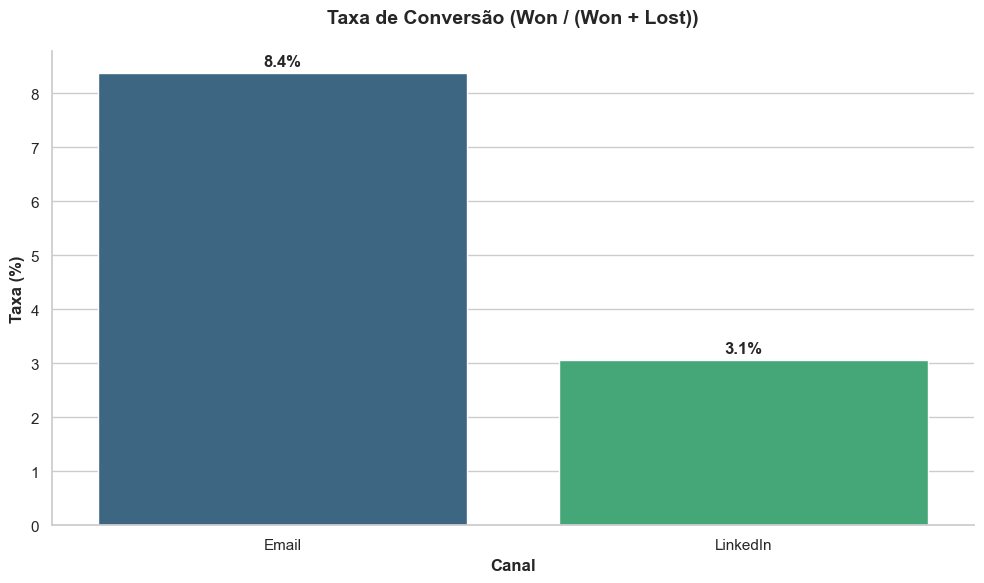

In [17]:
# Visualização 1: Taxa de Conversão

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x=conversion_data.index,
    y="Conversion_Rate",
    data=conversion_data.reset_index(),
    ax=ax,
    palette="viridis",
)

ax.set_title(
    "Taxa de Conversão (Won / (Won + Lost))", fontweight="bold", fontsize=14, pad=20
)
ax.set_ylabel("Taxa (%)", fontweight="bold")
ax.set_xlabel("Canal", fontweight="bold")

# Adicionar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3, fontweight="bold")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

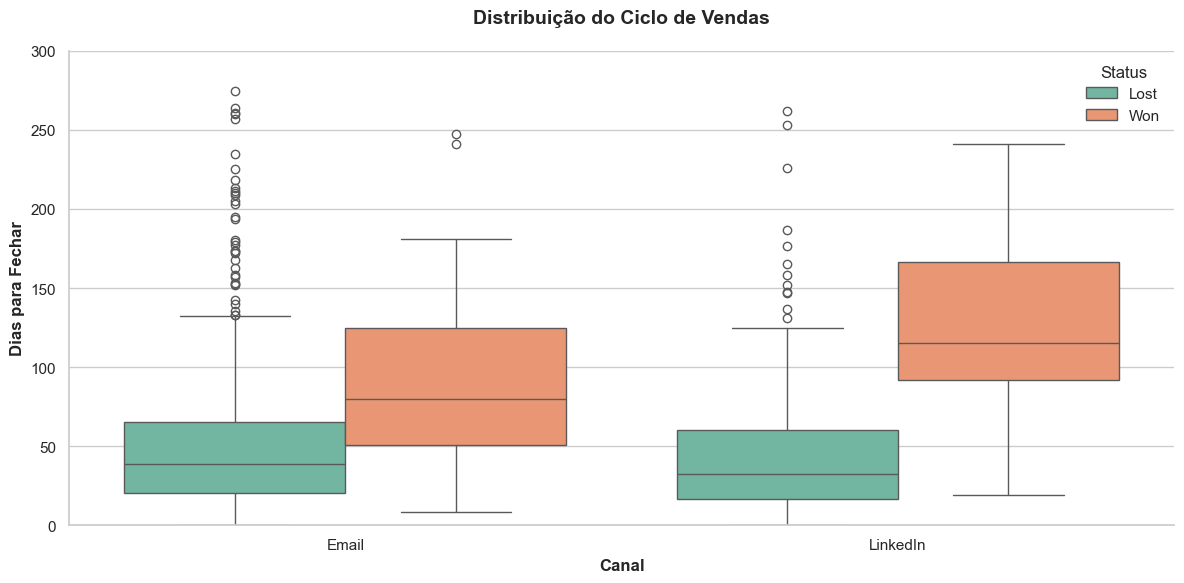

In [18]:
# Visualização 2: Distribuição do Ciclo de Vendas

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    x="Suborigem",
    y="Days_to_Close",
    hue="Status",
    data=df[df["Status"].isin(["Won", "Lost"])],
    ax=ax,
    palette="Set2",
)

ax.set_title("Distribuição do Ciclo de Vendas", fontweight="bold", fontsize=14, pad=20)
ax.set_ylabel("Dias para Fechar", fontweight="bold")
ax.set_xlabel("Canal", fontweight="bold")
ax.set_ylim(0, 300)  # Limitar para melhor visualização

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(title="Status", frameon=False)

plt.tight_layout()
plt.show()

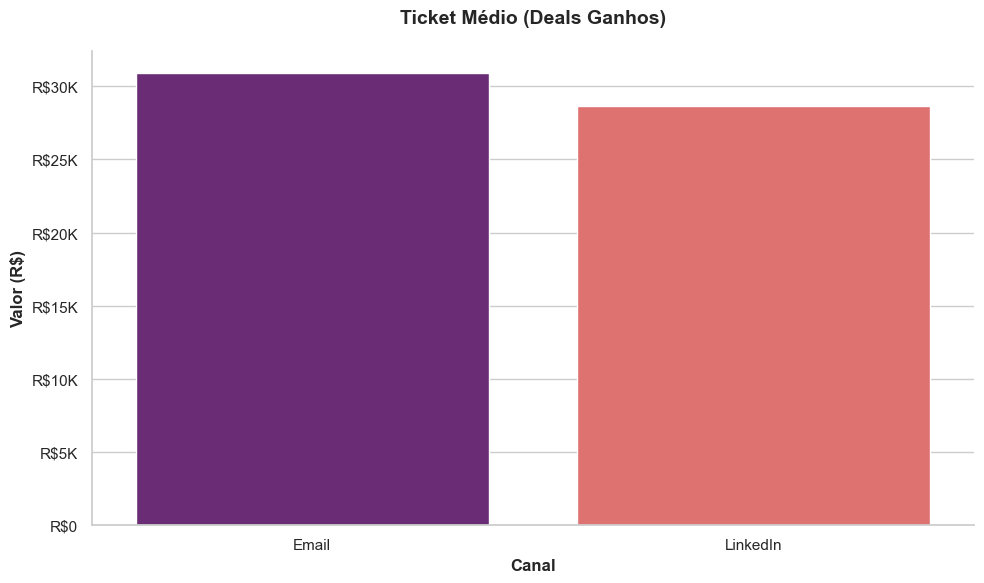

In [19]:
# Visualização 3: Ticket Médio

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x="Suborigem",
    y="Value_Clean",
    data=df[df["Status"] == "Won"],
    estimator=np.mean,
    errorbar=None,
    ax=ax,
    palette="magma",
)

ax.set_title("Ticket Médio (Deals Ganhos)", fontweight="bold", fontsize=14, pad=20)
ax.set_ylabel("Valor (R$)", fontweight="bold")
ax.set_xlabel("Canal", fontweight="bold")
ax.yaxis.set_major_formatter(FuncFormatter(format_currency_br))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

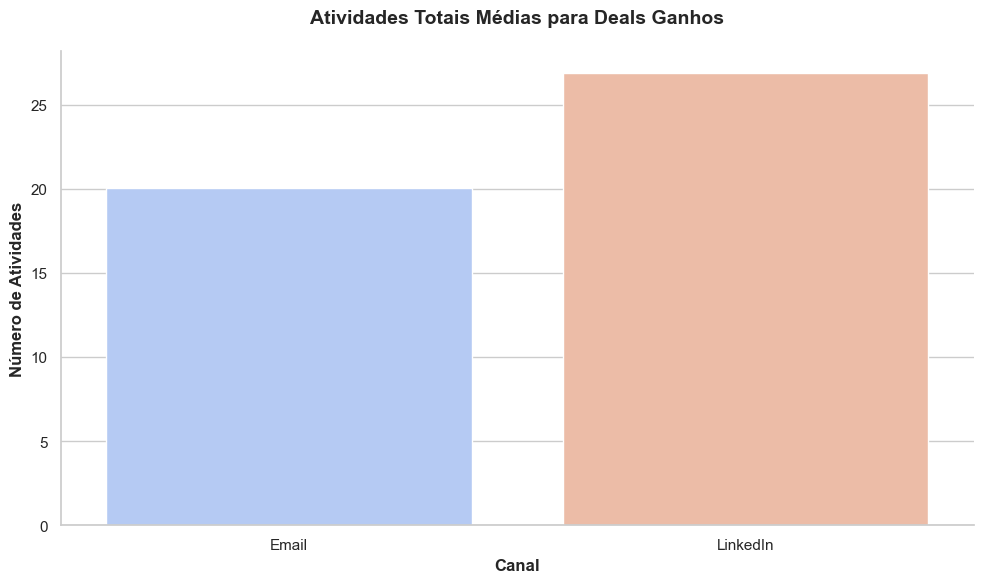

In [20]:
# Visualização 4: Atividades Totais Médias

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x="Suborigem",
    y="Total activities",
    data=df[df["Status"] == "Won"],
    estimator=np.mean,
    errorbar=None,
    ax=ax,
    palette="coolwarm",
)

ax.set_title(
    "Atividades Totais Médias para Deals Ganhos", fontweight="bold", fontsize=14, pad=20
)
ax.set_ylabel("Número de Atividades", fontweight="bold")
ax.set_xlabel("Canal", fontweight="bold")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

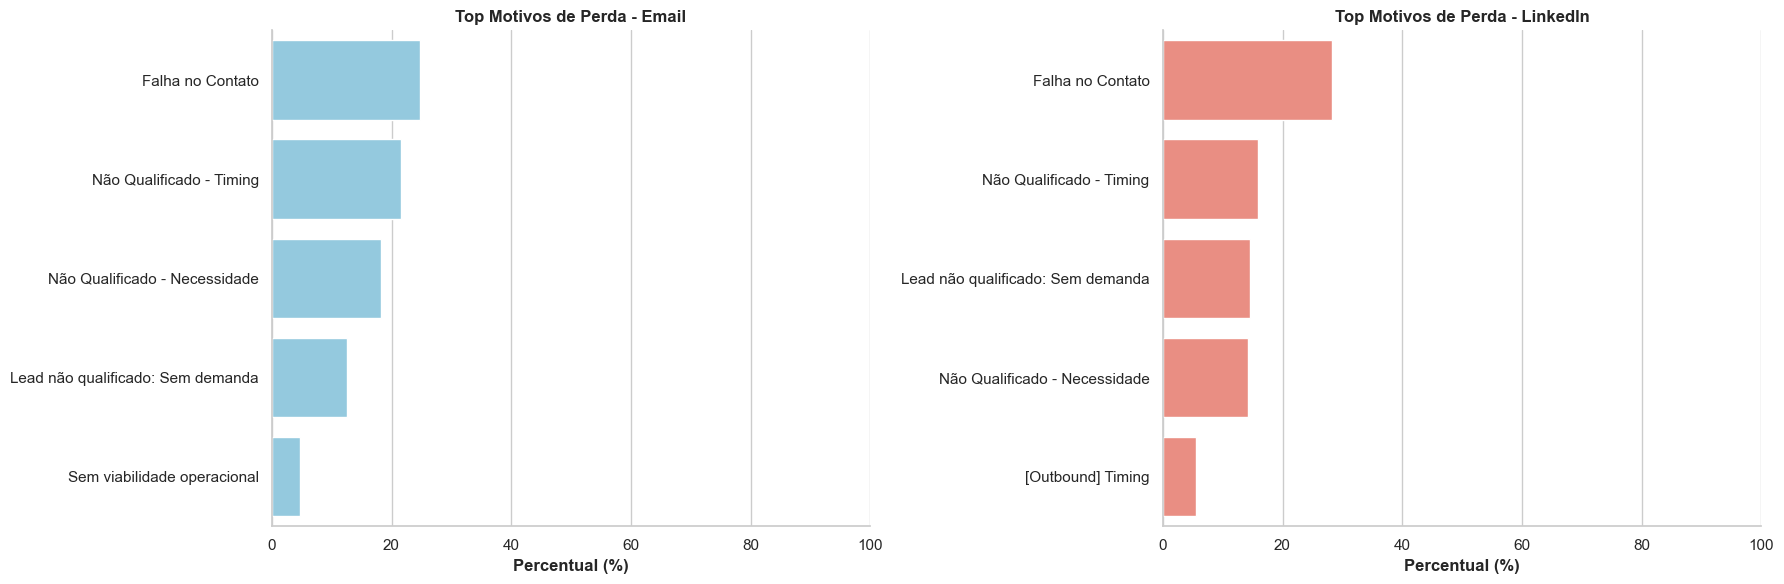

In [21]:
# Visualização 5: Top Motivos de Perda

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Email
sns.barplot(
    y="Motivo da perda", x="Percentage", data=top_loss_email, ax=ax1, color="skyblue"
)
ax1.set_title("Top Motivos de Perda - Email", fontweight="bold", fontsize=12)
ax1.set_xlabel("Percentual (%)", fontweight="bold")
ax1.set_ylabel("")
ax1.set_xlim(0, 100)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# LinkedIn
sns.barplot(
    y="Motivo da perda", x="Percentage", data=top_loss_linkedin, ax=ax2, color="salmon"
)
ax2.set_title("Top Motivos de Perda - LinkedIn", fontweight="bold", fontsize=12)
ax2.set_xlabel("Percentual (%)", fontweight="bold")
ax2.set_ylabel("")
ax2.set_xlim(0, 100)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()